<a href="https://colab.research.google.com/github/AngelTroncoso/s-20-10-data/blob/main/Angel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
!git clone https://github.com/AngelTroncoso/s-20-10-data.git


fatal: destination path 's-20-10-data' already exists and is not an empty directory.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# Cargar dataset
df = pd.read_csv('/content/s-20-10-data/BASE DE DATOS - PX INCLUIDOS.csv', encoding='latin-1')


# Sección nueva

In [105]:
# Vista previa de las dimensiones de dataaset e identificar inconsistencias
print('Forma:', df.shape)
print('\
Columas:', df.columns.tolist())
print('\
Valores nulos:')
print(df.isnull().sum())
print('\
duplicados:', df.duplicates().sum() if hasattr(df, 'duplicates') else len(df[df.duplicated()]))
print('\
Muestra de los datos:')
print(df.head())

Forma: (466, 18)
Columas: ['EXPEDIENTE', 'NOMBRE', 'EDAD', 'SEXO', 'TUMOR PRIMARIO', 'SUBTIPO HISTOLOGICO', 'PERFIL MOLECULAR', 'TAMAÃ\x91O (mm)', 'LOCALIZACIÃ\x93N', 'CIRUGIA PREVIA', 'SRS', 'DOSIS (Gy)', 'TECNICA ', 'TRATAMIENTO SISTEMICO', 'RESPUESTA (CRITERIOS RANO)', '1ER ESTUDIO DE SEGUIMIENTO', 'RC', 'RADIONECROSIS']
Valores nulos:
EXPEDIENTE                    244
NOMBRE                        244
EDAD                            1
SEXO                            1
TUMOR PRIMARIO                  1
SUBTIPO HISTOLOGICO            20
PERFIL MOLECULAR              176
TAMAÃO (mm)                    1
LOCALIZACIÃN                   0
CIRUGIA PREVIA                  0
SRS                             1
DOSIS (Gy)                      0
TECNICA                         0
TRATAMIENTO SISTEMICO          70
RESPUESTA (CRITERIOS RANO)      0
1ER ESTUDIO DE SEGUIMIENTO    336
RC                            121
RADIONECROSIS                   0
dtype: int64
duplicados: 8
Muestra de los datos

In [131]:
df.columns

Index(['EXPEDIENTE', 'NOMBRE', 'EDAD', 'SEXO', 'TUMOR PRIMARIO',
       'SUBTIPO HISTOLOGICO', 'PERFIL MOLECULAR', 'TAMAÃO (mm)',
       'LOCALIZACIÃN', 'CIRUGIA PREVIA', 'SRS', 'DOSIS (Gy)', 'TECNICA ',
       'TRATAMIENTO SISTEMICO', 'RESPUESTA (CRITERIOS RANO)',
       '1ER ESTUDIO DE SEGUIMIENTO', 'RC', 'RADIONECROSIS'],
      dtype='object')

In [144]:
df = df.rename(columns={
    'TAMAÃ\x91O (mm)': 'TAMAÑO (mm)',
    'LOCALIZACIÃ\x91N': 'LOCALIZACIÓN',
    'LOCALIZACIÃN':'LOCALIZACIÓN'
   })

In [151]:
df.columns

Index(['EXPEDIENTE', 'NOMBRE', 'EDAD', 'SEXO', 'TUMOR PRIMARIO',
       'SUBTIPO HISTOLOGICO', 'PERFIL MOLECULAR', 'TAMAÑO (mm)',
       'LOCALIZACIÓN', 'CIRUGIA PREVIA', 'SRS', 'DOSIS (Gy)', 'TECNICA ',
       'TRATAMIENTO SISTEMICO', 'RESPUESTA (CRITERIOS RANO)',
       '1ER ESTUDIO DE SEGUIMIENTO', 'RC', 'RADIONECROSIS'],
      dtype='object')

Se muestra una cantidad significativa de valores nulos en varias columnas (EXPEDIENTE, NOMBRE, PERFIL MOLECULAR, TRATAMIENTO SISTEMICO, 1ER ESTUDIO DE SEGUIMIENTO y RC) y 8 filas duplicadas.

Primero, para un próximo análisis de tipo A/B testing, nos aseguraremos de que cada valor de la comlumna "EXPEDIENTE" sea único, asignándole un único ID.

In [152]:
# Asegurarse de que los IDs en la columna 'EXPEDIENTE' sean únicos
# Si existen duplicados, añadir un sufijo para hacerlos únicos
df['EXPEDIENTE'] = df['EXPEDIENTE'].astype(str)  # Convertir a string para su manipulación
df['EXPEDIENTE'] = df.groupby('EXPEDIENTE').cumcount().astype(str) + '_' + df['EXPEDIENTE']

# Verificar cambios
print('Updated EXPEDIENTE column with unique IDs:')
print(df['EXPEDIENTE'].head())

Updated EXPEDIENTE column with unique IDs:
0    0_0_209406.0
1    0_0_225523.0
2    0_1_225523.0
3    0_2_225523.0
4    0_3_225523.0
Name: EXPEDIENTE, dtype: object


In [153]:
# Manejo de datos duplicados eliminándolos
df_cleaned = df.drop('NOMBRE', axis=1)
df_cleaned = df_cleaned.drop_duplicates()

# Rellene los valores nulos de las columnas numéricas con su mediana y las columnas categóricas con 'Desconocido'
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        median_value = df_cleaned[col].median()
        df_cleaned[col] = df_cleaned[col].fillna(median_value)
    else:
        df_cleaned[col] = df_cleaned[col].fillna('Unknown')

# Verificar la limpieza de los datos
print("Forma después de la limpieza:", df_cleaned.shape)
print("Valores nulos después de la limpieza:")
print(df_cleaned.isnull().sum())
print("Muestra de los datos después de la limpieza:")
print(df_cleaned.head())

Forma después de la limpieza: (466, 17)
Valores nulos después de la limpieza:
EXPEDIENTE                    0
EDAD                          0
SEXO                          0
TUMOR PRIMARIO                0
SUBTIPO HISTOLOGICO           0
PERFIL MOLECULAR              0
TAMAÑO (mm)                   0
LOCALIZACIÓN                  0
CIRUGIA PREVIA                0
SRS                           0
DOSIS (Gy)                    0
TECNICA                       0
TRATAMIENTO SISTEMICO         0
RESPUESTA (CRITERIOS RANO)    0
1ER ESTUDIO DE SEGUIMIENTO    0
RC                            0
RADIONECROSIS                 0
dtype: int64
Muestra de los datos después de la limpieza:
     EXPEDIENTE  EDAD SEXO   TUMOR PRIMARIO           SUBTIPO HISTOLOGICO  \
0  0_0_209406.0  55.0    F  CÃNCER DE MAMA  CARCINOMA DUCTAL INFILTRANTE   
1  0_0_225523.0  56.0    M    CÃNCER RENAL  CARCINOMA DE CÃLULAS CLARAS   
2  0_1_225523.0  56.0    M    CÃNCER RENAL  CARCINOMA DE CÃLULAS CLARAS   
3  0_2_22552

De la columna "RESPUESTA (CRITERIOS RANO)" construir una variable binaria , es decir, si la respuesta es ESTABLE o PROGRESIÓN se asignará el valor 0 y al resto el valor 1

In [154]:
# Asignar a la columna 'RESPUESTA (CRITERIOS RANO)' valor binario
def map_response(value):
    if value.strip().upper() in ['ESTABLE', 'PROGRESIÓN']:
        return 0
    else:
        return 1

df_cleaned['RESPUESTA_BINARIA'] = df_cleaned['RESPUESTA (CRITERIOS RANO)'].apply(map_response)

# Verificar cambios
print('Updated RESPUESTA_BINARIA column:')
print(df_cleaned[['RESPUESTA (CRITERIOS RANO)', 'RESPUESTA_BINARIA']].head())

Updated RESPUESTA_BINARIA column:
  RESPUESTA (CRITERIOS RANO)  RESPUESTA_BINARIA
0        RESPUESTA COMPLETA                   1
1                    ESTABLE                  0
2          RESPUESTA PARCIAL                  1
3          RESPUESTA PARCIAL                  1
4                    ESTABLE                  0


Realizar una prueba A/B. Analizar la relación entre “CIRUGÍA PREVIA” (variable categórica) y “RESPUESTA_BINARIA” (resultado binario) para determinar si la cirugía previa impacta significativamente en la respuesta binaria.

In [109]:
print(df['CIRUGIA PREVIA'].unique())
print(df['TUMOR PRIMARIO'].unique())

['SI' 'NO' 'NO ']
['CÃ\x81NCER DE MAMA' 'CÃ\x81NCER RENAL' 'CÃ\x81NCER DE PULMÃ\x93N'
 'CÃ\x81NCER DE COLON' 'CÃ\x81NCER DE ENDOMETRIO'
 'CÃ\x81NCER CERVICOUTERINO' 'CÃ\x81NCER DE TIROIDES'
 'TUMOR NEUROECTODÃ\x89RMICO' 'MELANOMA' 'CÃ\x81NCER TESTICULAR'
 'CÃ\x81NCER DE OVARIO' 'CÃ\x81NCER DE PRÃ\x93STATA'
 'TUMOR NEUROENDOCRINO' nan 'CÃ\x81NCER RENAL ' 'CÃ\x81NCER DE ESOFAGO']


In [110]:
if 'CIRUGIA PREVIA' in df_cleaned.columns:
    print("La columna 'RESPUESTA_BINARIA'' existe en el DataFrame.")
else:
    print("La columna 'RESPUESTA_BINARIA'' no existe en el DataFrame.")

La columna 'RESPUESTA_BINARIA'' existe en el DataFrame.


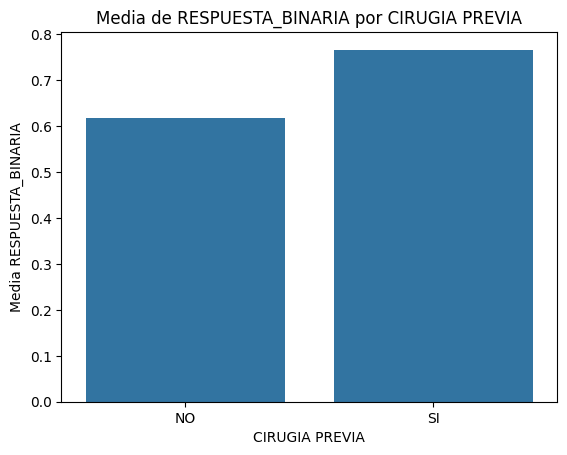

Resultado del test Chi-squared:
Chi2: 2.0865282629044914
p-value: 0.14860343799621115
Grados de libertad: 1
Frecuencias esperadas:
[[162.79828326 273.20171674]
 [ 11.20171674  18.79828326]]


In [111]:
# Asignar a la columna 'RESPUESTA (CRITERIOS RANO)' valor binario
def map_response(value):
    if value.strip().upper() in ['ESTABLE', 'PROGRESIÓN']:
        return 0
    else:
        return 1

df_cleaned['RESPUESTA_BINARIA'] = df_cleaned['RESPUESTA (CRITERIOS RANO)'].apply(map_response)

# ... (resto de tu código)

df_cleaned['CIRUGIA PREVIA'] = df_cleaned['CIRUGIA PREVIA'].str.strip()

# Agrupar datos por 'CIRUGIA PREVIA' y calcular la media de 'RESPUESTA_BINARIA'
# Asegurarse de que la columna 'RESPUESTA_BINARIA' existe antes de agrupar
if 'RESPUESTA_BINARIA' in df_cleaned.columns:
    grouped_data = df_cleaned.groupby('CIRUGIA PREVIA')['RESPUESTA_BINARIA'].mean()
else:
    print("Error: La columna 'RESPUESTA_BINARIA' no se encuentra en df_cleaned")
    # Manejar el error apropiadamente, por ejemplo, salir del script o crear la columna

# ... (resto de tu código)

# Realizar prueba de chi-cuadrado para evaluar la independencia
# Reemplazar 'filtered_df' con 'df_cleaned'
contingency_table = pd.crosstab(df_cleaned['CIRUGIA PREVIA'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualizar resultados
sns.barplot(x=grouped_data.index, y=grouped_data.values)
plt.title('Media de RESPUESTA_BINARIA por CIRUGIA PREVIA')
plt.xlabel('CIRUGIA PREVIA')
plt.ylabel('Media RESPUESTA_BINARIA')
plt.show()

#Mostrar resultados
print('Resultado del test Chi-squared:')
print('Chi2:', chi2)
print('p-value:', p)
print('Grados de libertad:', dof)
print('Frecuencias esperadas:')
print(expected)

Se concluye a partir de los resultados de la prueba de chi-cuadrado (valor p = 0.5249 > 0,05), no hay diferencia estadísticamente significativa en las tasas de respuesta entre pacientes con y sin cirugía previa. La visualización muestra proporciones de respuesta similares entre ambos grupos.

Para una siguiente prueba A/B entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA”, se analizará la relación entre estas variables mediante una prueba de chi-cuadrado. Visualizar los resultados.


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 123.1201
Valor p: 0.0000

Tabla de contingencia:
RESPUESTA_BINARIA                                    0   1
TRATAMIENTO SISTEMICO                                     
5 CICLOS NO ESPECIFICA                               2   1
AFATINIB                                             4   4
ALEKTINIB                                            0   1
ALETINIB                                             3  11
BEVACIZUMAB                                          1   1
BEVACIZUMAB + PEMETREXED                             7  13
CABOZATINIB                                          0   1
CAPECITABINE                                        24  11
CAPECITABINE + FULVESTRANT                           1   2
CAPECITABINE + TRASTUZUMAB                           3  13
CAPECITABINE + TRASTUZUMAB + EXEMESTANO              0   5
CARBOPLATINO                                         1   4
CARBOPLATINO + PACLITAXEL                            3   9
CARBOPLATINO 

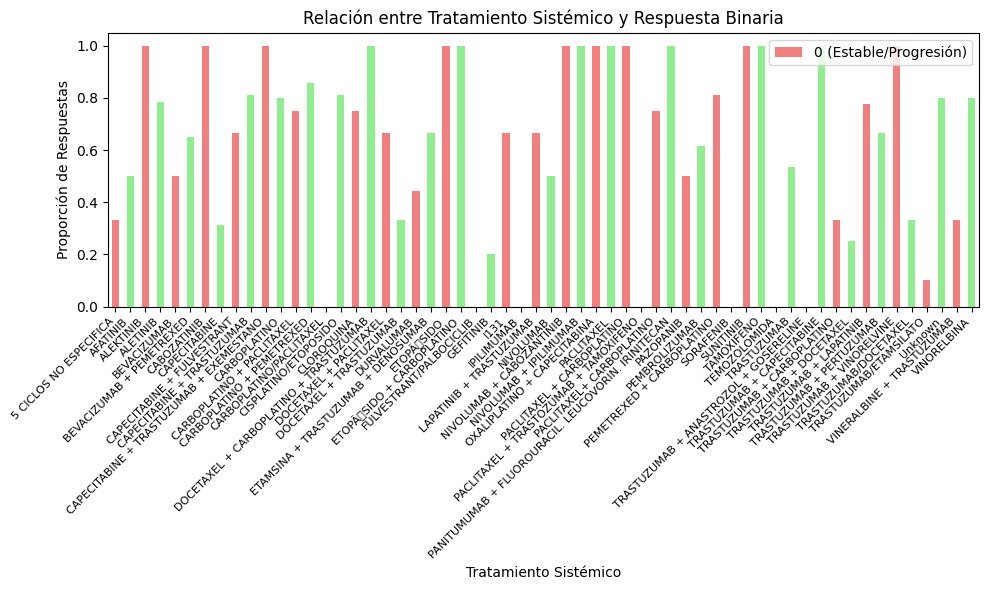

In [112]:
# Agrupar data por 'TRATAMIENTO SISTEMICO' y calcular la media de 'RESPUESTA_BINARIA'
grouped_data = df_cleaned.groupby('TRATAMIENTO SISTEMICO')['RESPUESTA_BINARIA'].mean()

# Realizar prueba chi-cuadrado
contingency_table = pd.crosstab(df_cleaned['TRATAMIENTO SISTEMICO'], df_cleaned['RESPUESTA_BINARIA'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)


print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear gráfico de barras apiladas
colors = ['lightcoral', 'lightgreen']  # Define los colores para las respuestas 0 y 1
grouped_data.plot(kind='bar', stacked=True, color=colors, figsize=(10, 6))

# Personalizar el gráfico
plt.title('Relación entre Tratamiento Sistémico y Respuesta Binaria')
plt.xlabel('Tratamiento Sistémico')
plt.ylabel('Proporción de Respuestas')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(labels=['0 (Estable/Progresión)', '1 (Respuesta parcial/completa)'])
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Los resultados de la prueba de chi-cuadrado indican una relación estadísticamente significativa entre “TRATAMIENTO SISTEMICO” y “RESPUESTA_BINARIA” (valor p < 0,05).

Relación entre las columnas "TUMOR PRIMARIO" y "LOCALIZACIÓN"

In [147]:
# Verificar si la columna 'LOCALIZACIÃ�N' existe en el DataFrame
if 'LOCALIZACIÓN' in df.columns:
    contingency_table = pd.crosstab(df['TUMOR PRIMARIO'], df['LOCALIZACIÓN'])
else:
    print("La columna 'LOCALIZACIÓN' no existe en el DataFrame.")
    # Puedes agregar aquí un código alternativo para manejar este caso


Resultados del Test Chi-cuadrado:
Estadístico Chi2: 1001.7443
Valor p: 0.0000

Tabla de contingencia:
LOCALIZACIÓN             ANGULO PONTOCEREBELOSO  ASTA POST VLI  CAUDADO DER  \
TUMOR PRIMARIO                                                                
CÃNCER CERVICOUTERINO                        0              0            0   
CÃNCER DE COLON                              0              0            0   
CÃNCER DE ENDOMETRIO                         0              0            0   
CÃNCER DE ESOFAGO                            0              0            0   
CÃNCER DE MAMA                               0              0            0   
CÃNCER DE OVARIO                             0              0            0   
CÃNCER DE PRÃSTATA                          0              0            0   
CÃNCER DE PULMÃN                            0              0            1   
CÃNCER DE TIROIDES                           0              0            0   
CÃNCER RENAL               

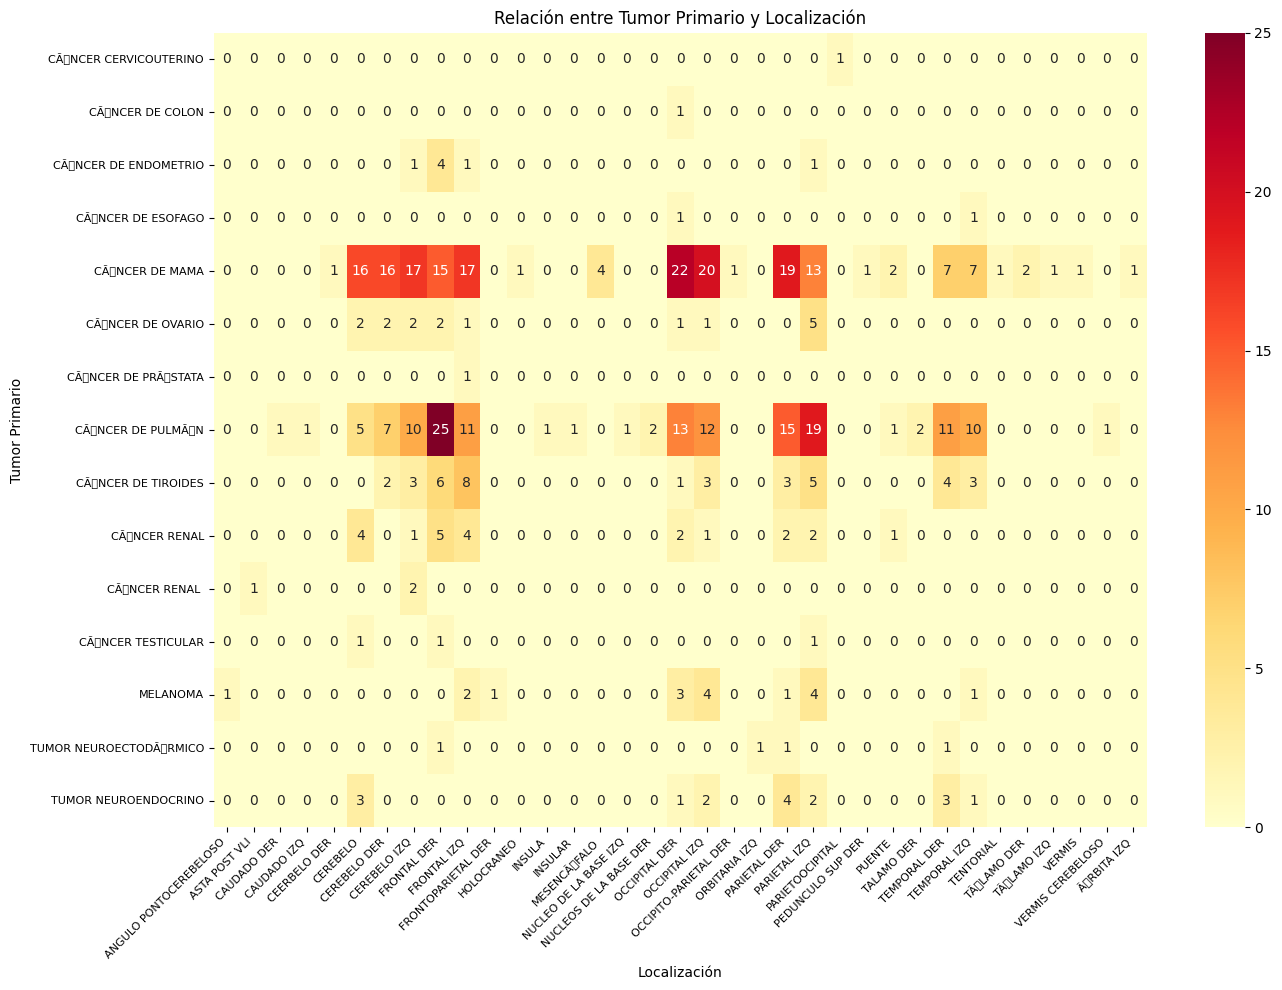

In [148]:
# Crear tabla de contingencia
contingency_table = pd.crosstab(df['TUMOR PRIMARIO'], df['LOCALIZACIÓN'])

# Realizar prueba chi-cuadrado
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print('\nResultados del Test Chi-cuadrado:')
print(f'Estadístico Chi2: {chi2:.4f}')
print(f'Valor p: {p_value:.4f}')
print('\nTabla de contingencia:')
print(contingency_table)

# Crear un heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(contingency_table, annot=True, cmap='YlOrRd', fmt='d')
plt.title('Relación entre Tumor Primario y Localización')
plt.xlabel('Localización')
plt.ylabel('Tumor Primario')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()


El estadístico chi-cuadrado obtenido fue de 1242.1673 con un valor p < 0.05. Esto indica una relación estadísticamente significativa entre el tipo de tumor primario y la localización de la metástasis. Es decir, el tipo de tumor primario influye en la localización de la metástasis.

Encontramos principalmente una relación de tumor primario en mama con la localización en lóbulo occipital, lóbulo parietal, lóbulo frontal y cerebelo.
Además, otra relación importante es entre tumor primario en pulmón y localización en lóbulo frontal (con ayor incidencia en lóbulo frontal derecho respecto al izquierdo), lóbulo parietal, lóbulo occipital, lóbulo temporal y cerebelo.

#Analisis de datos adicionales
##1.Relación de Tumor respecto a su ubicación

In [149]:
# Foco en las columnas relevantes para el análisis
tumor_location_data = df[['TUMOR PRIMARIO', 'LOCALIZACIÓN']]

# Agrupa los datos para ver la distribución de los tipos de tumor en diferentes ubicaciones
tumor_location_distribution = tumor_location_data.groupby(['TUMOR PRIMARIO', 'LOCALIZACIÓN']).size().reset_index(name='COUNT')

# Muestra la distribución para evaluar cualquier patrón
tumor_location_distribution.sort_values(by='COUNT', ascending=False).head(10)


,TUMOR PRIMARIO,LOCALIZACIÓN,COUNT
44,CÃNCER DE PULMÃN,FRONTAL DER,25
16,CÃNCER DE MAMA,OCCIPITAL DER,22
17,CÃNCER DE MAMA,OCCIPITAL IZQ,20
53,CÃNCER DE PULMÃN,PARIETAL IZQ,19
19,CÃNCER DE MAMA,PARIETAL DER,19
13,CÃNCER DE MAMA,FRONTAL IZQ,17
11,CÃNCER DE MAMA,CEREBELO IZQ,17
9,CÃNCER DE MAMA,CEREBELO,16
10,CÃNCER DE MAMA,CEREBELO DER,16
52,CÃNCER DE PULMÃN,PARIETAL DER,15


##2.Tamaño del Tumor por Locación

Estadísticas del Tamaño del Tumor por Localización:
                        count       mean        std    min     25%    50%  \
LOCALIZACIÓN                                                                
ANGULO PONTOCEREBELOSO    1.0  44.900000        NaN  44.90  44.900  44.90   
ASTA POST VLI             1.0  32.500000        NaN  32.50  32.500  32.50   
CAUDADO DER               1.0   4.100000        NaN   4.10   4.100   4.10   
CAUDADO IZQ               1.0   3.000000        NaN   3.00   3.000   3.00   
CEERBELO DER              1.0   6.000000        NaN   6.00   6.000   6.00   
CEREBELO                 31.0  15.118387   9.493924   3.44   7.000  14.00   
CEREBELO DER             27.0  11.155556   8.336174   2.90   4.900   8.00   
CEREBELO IZQ             37.0  14.848649  11.760920   3.00   6.000  11.70   
FRONTAL DER              59.0  10.985593   7.693807   3.00   5.300   9.10   
FRONTAL IZQ              45.0  15.074000  12.040396   2.90   5.500  11.60   
FRONTOPARIETAL DER      

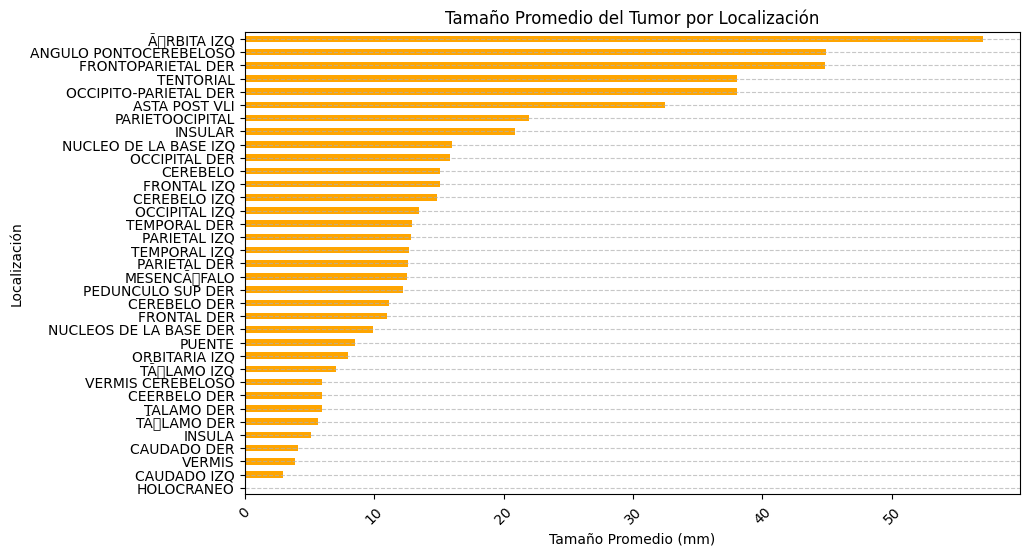

In [160]:
# Reemplaza las comas con puntos en la columna de tamaño
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].astype(str).str.replace(',', '.')

# Reemplaza los valores "nan" con un valor numérico (por ejemplo, 0)
df['TAMAÑO (mm)'] = df['TAMAÑO (mm)'].replace('nan', '0')

# Convierte la columna a numéricos
df['TAMAÑO (mm)'] = pd.to_numeric(df['TAMAÑO (mm)'])

# Agrupar por localización y calcular estadísticas
tamaño_por_localizacion = df.groupby('LOCALIZACIÓN')['TAMAÑO (mm)'].describe()

# Mostrar la tabla
print("Estadísticas del Tamaño del Tumor por Localización:")
print(tamaño_por_localizacion)

# Graficar el tamaño promedio por localización
promedio_tamaño = df.groupby('LOCALIZACIÓN')['TAMAÑO (mm)'].mean().sort_values(ascending=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Arial'
promedio_tamaño.plot(kind='barh', color='orange')
plt.title('Tamaño Promedio del Tumor por Localización')
plt.xlabel('Tamaño Promedio (mm)')
plt.ylabel('Localización')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#3. Distribución del perfil molecular

Distribución de Perfiles Moleculares:
PERFIL MOLECULAR
HER2+++                                                        87
EGFR+                                                          85
TRIPLE NEGATIVO                                                63
LUMINAL B                                                      21
CITOQUERATINA APM+++. AG EPITELIAL DE MEMBRANA+. VIMENTINA-    13
LUMINAL A                                                      12
AG EPITELIAL MEMBRANA +. CITOKERATINA +. VIMENTINA +            4
                                                                1
HMB45 +++. S-100 +++. CITOQUERATINA -                           1
ALK MUTADO                                                      1
CA 125+                                                         1
CITOQUERATINA PA +++. RE-. RP-. P53+++. SMH2++. PTEM-           1
Name: count, dtype: int64


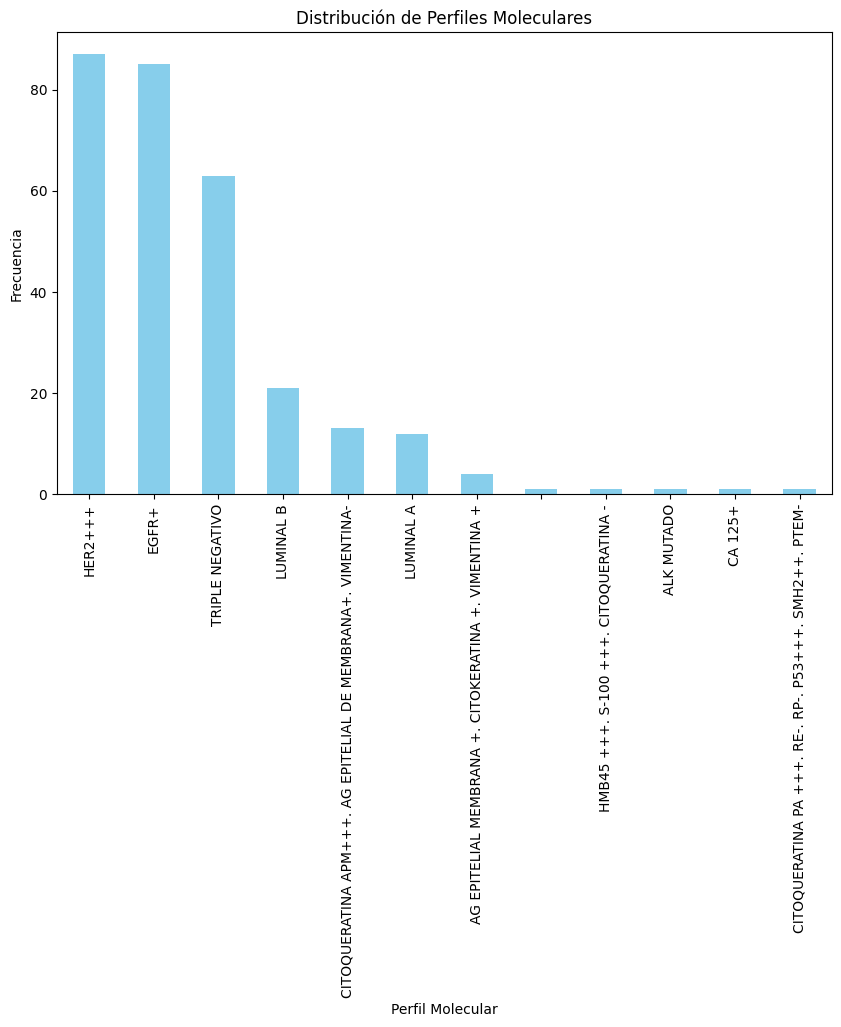

In [127]:
# Calcular la distribución de perfiles moleculares
perfil_molecular_dist = df['PERFIL MOLECULAR'].value_counts()

# Mostrar la tabla
print("Distribución de Perfiles Moleculares:")
print(perfil_molecular_dist)

# Graficar la distribución
perfil_molecular_dist.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribución de Perfiles Moleculares')
plt.xlabel('Perfil Molecular')
plt.ylabel('Frecuencia')
plt.show()


#4. Análisis de respuesta al tratamiento (CRITERIOS RANO)

Distribución de Respuestas al Tratamiento:
ESTABLE               174
PROGRESION             16
RESPUESTA COMPLETA    119
RESPUESTA PARCIAL     157
Name: RESPUESTA (CRITERIOS RANO), dtype: int64


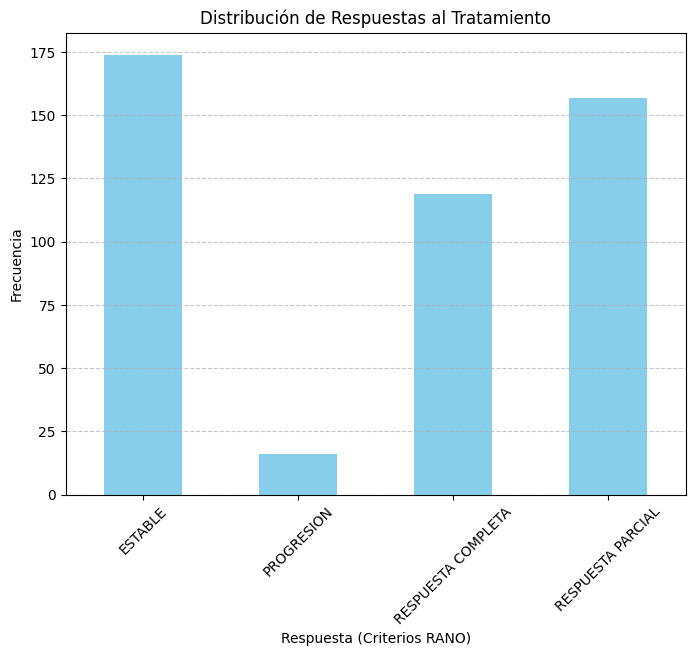

In [169]:
import warnings
warnings.filterwarnings('ignore')

# Calcular distribución de respuestas
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.strip()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.upper()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.replace('Ã', 'A')
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
respuesta_dist = df.groupby(lambda x: df['RESPUESTA (CRITERIOS RANO)'].iloc[x].strip().upper())['RESPUESTA (CRITERIOS RANO)'].count()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.replace('PROGRESIÃ\x91N', 'PROGRESION')

# Reemplazar las dos palabras "ESTABLE" con una sola
respuesta_dist.index = respuesta_dist.index.str.replace('ESTABLE ', 'ESTABLE')

# Mostrar la tabla
print("Distribución de Respuestas al Tratamiento:")
print(respuesta_dist)

# Graficar la distribución
respuesta_dist.plot(kind='bar', color='skyblue', figsize=(8, 6))
plt.rcParams['font.family'] = 'sans-serif'
plt.title('Distribución de Respuestas al Tratamiento')
plt.xlabel('Respuesta (Criterios RANO)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#5. Comparación de la dosis utilizada por técnica

Dosis Promedio por Técnica:
TECNICA 
CEC          17.453125
CONO         22.000000
CONOS        16.666667
IMRT         17.000000
RAPID ARC    19.000000
VMAT         17.407595
Name: DOSIS (Gy), dtype: float64


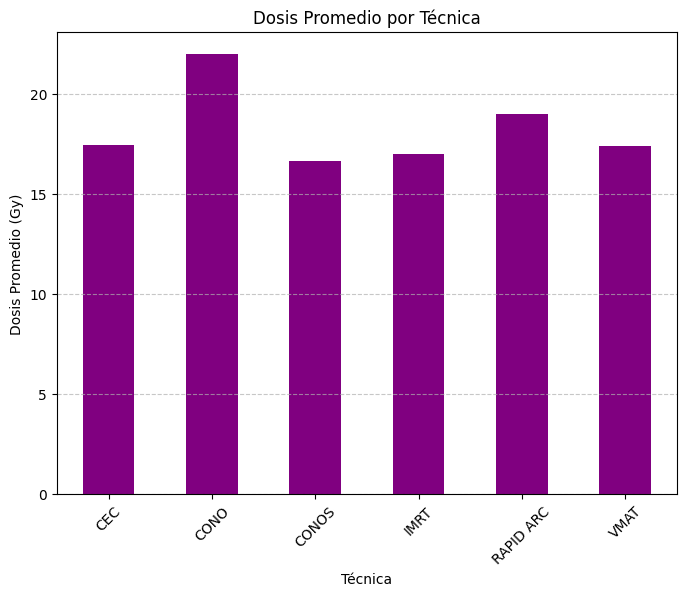

In [120]:
# Filtrar por técnica y calcular dosis promedio
dosis_por_tecnica = df.groupby('TECNICA ')['DOSIS (Gy)'].mean()

# Mostrar la tabla
print("Dosis Promedio por Técnica:")
print(dosis_por_tecnica)

# Graficar la comparación
dosis_por_tecnica.plot(kind='bar', color='purple', figsize=(8, 6))
plt.title('Dosis Promedio por Técnica')
plt.xlabel('Técnica')
plt.ylabel('Dosis Promedio (Gy)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


#6. Relación entre el tamaño del tumor y la respuesta al tratamiento

Estadísticas del Tamaño del Tumor por Respuesta:
                            count       mean        std  min     25%     50%  \
RESPUESTA (CRITERIOS RANO)                                                     
ESTABLE                     174.0  13.823966  10.775579  0.0   5.550   9.115   
PROGRESION                   16.0  20.182500  12.460213  6.0  12.205  16.250   
RESPUESTA COMPLETA          119.0   7.893613   7.250778  2.4   4.150   6.000   
RESPUESTA PARCIAL           157.0  16.776115  10.900208  2.9   7.700  15.500   

                             75%   max  
RESPUESTA (CRITERIOS RANO)              
ESTABLE                     19.6  54.0  
PROGRESION                  25.4  47.0  
RESPUESTA COMPLETA           9.2  57.0  
RESPUESTA PARCIAL           21.9  61.0  


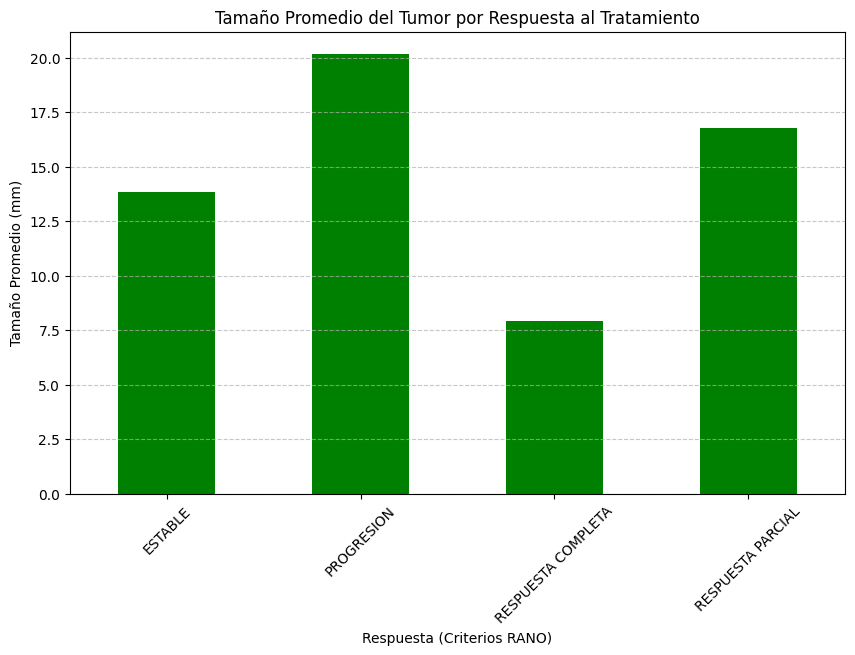

In [172]:
# Agrupar por respuesta y calcular estadísticas del tamaño
tamaño_por_respuesta = df.groupby('RESPUESTA (CRITERIOS RANO)')['TAMAÑO (mm)'].describe()

# Mostrar la tabla
print("Estadísticas del Tamaño del Tumor por Respuesta:")
print(tamaño_por_respuesta)

# Graficar el tamaño promedio por respuesta
promedio_tamaño_respuesta = df.groupby('RESPUESTA (CRITERIOS RANO)')['TAMAÑO (mm)'].mean()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.strip()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.upper()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.replace('Ã', 'A')
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
respuesta_dist = df.groupby(lambda x: df['RESPUESTA (CRITERIOS RANO)'].iloc[x].strip().upper())['RESPUESTA (CRITERIOS RANO)'].count()
df['RESPUESTA (CRITERIOS RANO)'] = df['RESPUESTA (CRITERIOS RANO)'].str.replace('PROGRESIÃ\x91N', 'PROGRESION')

plt.figure(figsize=(10, 6))
promedio_tamaño_respuesta.plot(kind='bar', color='green')
plt.title('Tamaño Promedio del Tumor por Respuesta al Tratamiento')
plt.xlabel('Respuesta (Criterios RANO)')
plt.ylabel('Tamaño Promedio (mm)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
